In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('games-features.csv');

In [3]:
df.drop(columns=['RequiredAge', 'PCReqsHaveMin', 'PCReqsHaveRec', 'LinuxReqsHaveMin', 'LinuxReqsHaveRec', 
                 'MacReqsHaveMin', 'MacReqsHaveRec', 'Website', 'PCMinReqsText', 'PCRecReqsText', 
                 'LinuxMinReqsText', 'LinuxRecReqsText', 'MacMinReqsText', 'MacRecReqsText',
                'SupportEmail', 'SupportURL', 'AboutText', 'Background', 'ShortDescrip', 
                 'DetailedDescrip', 'DRMNotice', 'ExtUserAcctNotice', 'HeaderImage', 'LegalNotice', 'Reviews', 'DeveloperCount'],
        inplace = True
       );

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13357 entries, 0 to 13356
Data columns (total 52 columns):
QueryID                        13357 non-null int64
ResponseID                     13357 non-null int64
QueryName                      13356 non-null object
ResponseName                   13357 non-null object
ReleaseDate                    13357 non-null object
DemoCount                      13357 non-null int64
DLCCount                       13357 non-null int64
Metacritic                     13357 non-null int64
MovieCount                     13357 non-null int64
PackageCount                   13357 non-null int64
RecommendationCount            13357 non-null int64
PublisherCount                 13357 non-null int64
ScreenshotCount                13357 non-null int64
SteamSpyOwners                 13357 non-null int64
SteamSpyOwnersVariance         13357 non-null int64
SteamSpyPlayersEstimate        13357 non-null int64
SteamSpyPlayersVariance        13357 non-null int64
Achi

In [5]:
df['Relised'] = True

In [6]:
df['ReleaseDateStr'] = df['ReleaseDate']

In [7]:
def conert_str_to_date(df, key):
    years_ = ['2016', '2017', '2019',]
    soon_ = 'skoro|someday|20XX|coming|announced|soon|tba|tbc|tbd|early|-|breve'
    periods_ = {
        'q1|Q1': 'Feb',
        'q2|q 2 ': 'May',
        'q3': 'Aug',
        'q4': 'Nov',
        'mid': 'Jul',
        'fall|autumn|utumn': 'Oct',
        'end': 'Dec',
        'spring': 'Apr',
        'winter': 'Dec',
        'summer': 'Jul',
        'january': 'Jan', 
        'february': 'Feb',
        'march': 'Mar',
        'april': 'Apr',
        #'may': 'May',
        'june': 'Jun',
        'july': 'Jul',
        'august': 'Aug',
        'september': 'Sep',
        'october': 'Oct',
        'november': 'Nov',
        'december': 'Dec'
    }
    
    for period_, month_ in periods_.items():
        for year_ in years_:
            df.loc[(df[key].str.contains(period_, case=False)) & (df[key].str.contains(year_)), [key, 'Relised']] = month_ + ' ' + year_, False
        df.loc[(df[key].str.contains(period_, case=False)), [key, 'Relised']] = month_ + ' 2017', False
    for year_ in years_:
        df.loc[((df[key].str.len() != 8) & (df[key].str.len() != 10) & (df[key].str.len() != 11)) & (df[key].str.contains(year_)), [key, 'Relised']] = year_, False
    df.loc[df[key].str.contains(soon_, case=False), [key, 'Relised']] = '2017', False
    df.loc[(df[key].str.len() != 4) & (df[key].str.len() != 8) & (df[key].str.len() != 10) & (df[key].str.len() != 11), [key]] = '2017'

In [8]:
conert_str_to_date(df, 'ReleaseDate')

In [9]:
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'])

In [10]:
df["ReleaseDate"] = df["ReleaseDate"].astype("datetime64")

In [11]:
df["ReleaseYear"] = df["ReleaseDate"].dt.year
df["ReleaseMonth"] = df["ReleaseDate"].dt.month
df["ReleaseDay"] = df["ReleaseDate"].dt.day

In [12]:
df.loc[(df['Relised'] == False)]['QueryID'].count()

601

In [13]:
df.loc[(df['GenreIsNonGame'] == True)]['QueryID'].count()

319

### Исключить из списка не игры, а так же не вышедшие или в раннем доступе, по стостянию на 2016 год

In [14]:
df['QueryID'].count()

13357

In [15]:
df = df.loc[
    (df['Relised'] == True) & 
    (df['GenreIsNonGame'] == False) & 
    (
        (df['GenreIsEarlyAccess'] == False) | 
        (
            (df['GenreIsEarlyAccess'] == True) & (df['SteamSpyOwners'] > 0)
        )
    )]

In [16]:
df['QueryID'].count()

12099

### Удалить дубликаты

In [17]:
df.drop_duplicates(subset='ResponseID', keep="first", inplace=True);

In [18]:
df['QueryID'].count()

11951

## Рассчет потенциальной выручки (без учета скидок и распродаж и региональных цен) по состоянию на 2016 год

In [19]:
df['PotentialRevenue'] = df['PriceFinal'] * df['SteamSpyOwners']

### Рост кол-ва игр на Steam по состоянию на 2016 год

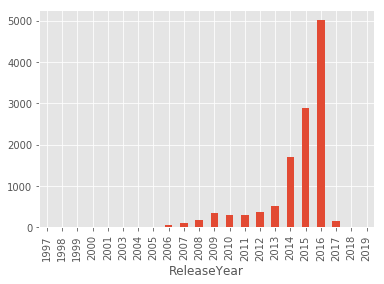

In [20]:
df.groupby(df["ReleaseYear"])['QueryID'].count().plot(kind="bar")

### Периодичность по месяцам

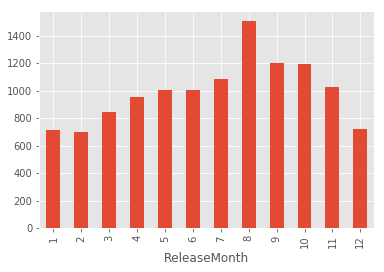

In [21]:
df.groupby(df["ReleaseMonth"])['QueryID'].count().plot(kind="bar")

In [22]:
genres_list = [
    'GenreIsIndie',
    'GenreIsAction',
    'GenreIsAdventure',
    'GenreIsCasual',
    'GenreIsStrategy',
    'GenreIsRPG',
    'GenreIsSimulation',
    #'GenreIsEarlyAccess'
    #'GenreIsFreeToPlay',
    'GenreIsSports',
    'GenreIsRacing',
    'GenreIsMassivelyMultiplayer',
]
genres_dicts = []
for g in genres_list: 
    lst = np.array(df.loc[(df[g] == True) & (df['PotentialRevenue'] > 0), 'PotentialRevenue'])
    genres_dicts.append({
        'name': g,
        'lst': lst,
        'n': len(lst),
        'mean': lst.mean()
    })
#print(genres_dicts)  

## Дисперсионный анализ влияние жанра на потенциальную выручку

Влияет ли выбор жанра игры на потенциальную выручку?

Влияет ли фактор "жанр", на состояние потенциальной выручки

In [23]:
all_lst = np.array([])
for g in genres_dicts:
    all_lst = np.concatenate([all_lst, g['lst']])

In [24]:
k = len(genres_dicts)
n = len(all_lst)
print(k, n)

10 21359


In [25]:
all_mean = all_lst.mean()
all_mean

2050999.9528166112

In [26]:
s2 = np.sum((all_lst - all_mean)**2)
s2

2.394983759287706e+18

In [27]:
s2_f = 0
for g in genres_dicts:
    s2_f += ((g['mean'] - all_mean)**2) * g['n']
print(s2_f)

2.6226712180297964e+16


In [28]:
s2_residual = 0
for g in genres_dicts:
    s2_residual += np.sum((g['lst'] - g['mean'])**2)
s2_residual

2.3687570471074074e+18

In [29]:
print(s2)
print(s2_f + s2_residual)

2.394983759287706e+18
2.394983759287705e+18


In [30]:
sigma2_general = s2 / (n - 1)
sigma2_general

112135207383074.55

In [31]:
sigma2_f = s2_f / (k - 1)
sigma2_f

2914079131144218.0

In [32]:
sigma2_residual = s2_residual / (n - k)
sigma2_residual

110954004735931.77

In [33]:
F_h = sigma2_f / sigma2_residual
F_h

26.26384814211678

In [34]:
eta2 = s2_f / s2
eta2

0.010950684771281317

## Вывод

Выборки игр из 11 жанров и их прибыль не имеют статистистически значимых отличий

## А, что если есть такие 3 жанра, у которых значения будут статистически значимы?

Предыдущие вычисления запишу в функцию и перебором сравню получившуюся сигму

In [35]:
def find_eta2(dicts):
    a_lst = np.array([])
    for i in dicts:
        a_lst = np.concatenate([a_lst, i['lst']])
        
    k = len(dicts)
    n = len(a_lst)
    
    a_mean = a_lst.mean()
    s2 = np.sum((a_lst - a_mean)**2)

    s2_f = 0
    s2_residual = 0

    for i in dicts:
        s2_f += ((i['mean'] - a_mean)**2) * i['n']
        s2_residual += np.sum((i['lst'] - i['mean'])**2)
    sigma2_general = s2 / (n - 1)
    sigma2_f = s2_f / (k - 1)
    sigma2_residual = s2_residual / (n - k)
    F_h = sigma2_f / sigma2_residual
    eta2 = s2_f / s2
    
    return eta2

### Ручная проверка функции

In [36]:
find_eta2([genres_dicts[0], genres_dicts[1], genres_dicts[2]])

0.009295379343909517

In [38]:
l = len(genres_dicts)
max_eta2 = 0
for i in range(l):
    for j in range(i+1, l):
        for t in range(j+1, l):
            eta2 = find_eta2([genres_dicts[i], genres_dicts[j], genres_dicts[t]])
            #print(eta2)
            if eta2 > max_eta2:
                max_eta2 = eta2
                res = [genres_dicts[i]['name'], genres_dicts[j]['name'], genres_dicts[t]['name'], eta2]
print('Максимальные значения у комбинации трех жанров', res)

Максимальные значения у комбинации трех жанров ['GenreIsCasual', 'GenreIsRacing', 'GenreIsMassivelyMultiplayer', 0.041387180308460066]


### Вывод! Отдельно взятые 3 жанра, так же не имеют статистического значения на объем потенциальной выручки